In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import numpy as np

In [2]:
import matplotlib

In [ ]:
train_file = ""
test_file = ""
content_file = ""

In [3]:
data_train = pd.read_csv(
    train_file,
    sep=";",
    quotechar="|",
    header=None,
    names=['user', 'item', 'rating', 'time'],
    index_col=False
)

In [4]:
freqs = data_train.item.value_counts()

In [5]:
content = pd.read_csv(content_file, sep=' ', names=['item','category','category_name'])

# random init

In [6]:
random_log = pd.read_csv('logs/gru4rec_random.csv')
random_log['rank'] = (200-random_log['rank'])
random_log['mpr'] = random_log['rank']/200
random_log['ndcg'] = (random_log['rank']<=20)/np.log2(random_log['rank']+1)
random_log['recall'] = (random_log['rank']<=20)

In [7]:
random_log['rank'].mean(), random_log['mpr'].mean(), random_log['ndcg'].mean(), random_log['recall'].mean()

(30.311717002237135,
 0.15155858501119662,
 0.3215363670532131,
 0.6196868008948546)

# gru4rec best results (content filter)

In [8]:
gru4rec_log = pd.read_csv('logs/gru4rec.csv')
gru4rec_log['rank'] = (200-gru4rec_log['rank'])
gru4rec_log['mpr'] = gru4rec_log['rank']/200
gru4rec_log['ndcg'] = (gru4rec_log['rank']<=20)/np.log2(gru4rec_log['rank']+1)
gru4rec_log['recall'] = (gru4rec_log['rank']<=20)

In [9]:
gru4rec_log['rank'].mean(), gru4rec_log['mpr'].mean(), gru4rec_log['ndcg'].mean(), gru4rec_log['recall'].mean()

(17.87410514541387, 0.0893705257270769, 0.4667572174685208, 0.7986017897091723)

# fisher best results (content filter)

In [10]:
combined_order = pd.read_csv('logs/combined_order_filtered.csv')
jaccard_scores = np.load('logs/jaccard_scores.npy')
content_scores = np.load('logs/content_scores.npy')

In [11]:
jaccard_ranks = 200-(jaccard_scores[:,0].reshape(-1,1) > jaccard_scores[:,1:]).sum(axis=1)+(jaccard_scores[:,0].reshape(-1,1) == jaccard_scores[:,1:]).sum(axis=1)/2
content_ranks = 200-(content_scores[:,0].reshape(-1,1) > content_scores[:,1:]).sum(axis=1)+(content_scores[:,0].reshape(-1,1) == content_scores[:,1:]).sum(axis=1)/2

In [12]:
combined_order['jaccard_rank'] = jaccard_ranks
combined_order['content_rank'] = content_ranks
combined_order['jaccard_mpr'] = jaccard_ranks/200
combined_order['content_mpr'] = content_ranks/200
combined_order['jaccard_ndcg'] = (jaccard_ranks<=20)/np.log2(jaccard_ranks+1)
combined_order['content_ndcg'] = (content_ranks<=20)/np.log2(content_ranks+1)
combined_order['jaccard_recall'] = (jaccard_ranks<=20)
combined_order['content_recall'] = (content_ranks<=20)

In [13]:
combined_order['jaccard_rank'].mean(), combined_order['jaccard_mpr'].mean(), combined_order['jaccard_ndcg'].mean(), combined_order['jaccard_recall'].mean()

(16.886549217002237,
 0.0844327460850164,
 0.4371108225461014,
 0.7963087248322148)

In [14]:
combined_order['content_rank'].mean(), combined_order['content_mpr'].mean(), combined_order['content_ndcg'].mean(), combined_order['content_recall'].mean()

(19.77435682326622,
 0.09887178411634072,
 0.40216626668512934,
 0.7557606263982103)

# fisher collaborative+content combination

In [15]:
mprs = []
ndcgs = []
for a in np.linspace(0,1,21):
    scores = a*content_scores + (1-a)*jaccard_scores
    ranks = 200-(scores[:,0].reshape(-1,1) > scores[:,1:]).sum(axis=1)+(scores[:,0].reshape(-1,1) == scores[:,1:]).sum(axis=1)/2
    mprs.append(ranks.mean()/200)
    ndcgs.append(((ranks<=20)/np.log2(ranks+1)).mean())
    print("%.2f"%a, "\t", mprs[-1], "\t", ndcgs[-1])

0.00 	 0.08443274608501118 	 0.43711082254609157
0.05 	 0.08326775727069352 	 0.4396123652012863
0.10 	 0.0823709451901566 	 0.44082982888687733
0.15 	 0.0816631711409396 	 0.44240652681382325
0.20 	 0.08112597874720358 	 0.4431599272768691
0.25 	 0.0807767058165548 	 0.444166907808287
0.30 	 0.08065254474272932 	 0.44451797168660073
0.35 	 0.08064779082774048 	 0.4438780538515514
0.40 	 0.08084689597315436 	 0.44382054401192983
0.45 	 0.0812216163310962 	 0.44255849235350164
0.50 	 0.08174286912751677 	 0.44130544113762643
0.55 	 0.08248447986577181 	 0.43933159604209404
0.60 	 0.08337038590604028 	 0.4366192892966379
0.65 	 0.08438576621923938 	 0.43335857631032876
0.70 	 0.08570008389261745 	 0.4298894307798901
0.75 	 0.08717547539149889 	 0.4260497757008261
0.80 	 0.08887402125279642 	 0.4213706975737074
0.85 	 0.09092239932885907 	 0.4165406839305081
0.90 	 0.09322888702460849 	 0.4122675022322873
0.95 	 0.09586703020134228 	 0.40723999926411275
1.00 	 0.0988717841163311 	 0.40216

Text(0.5, 0, 'Weight of content score')

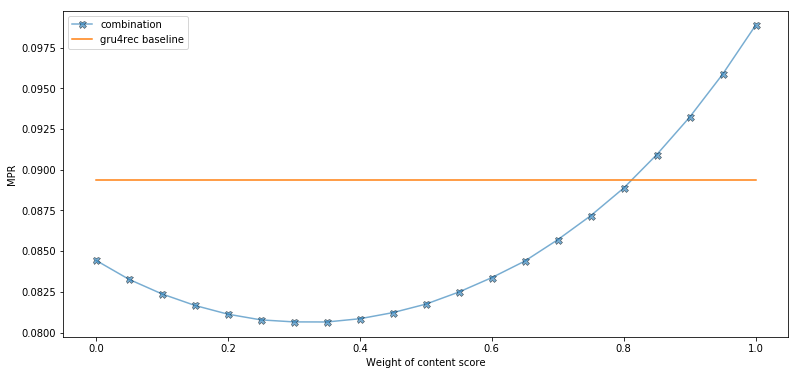

In [16]:
plt.figure(figsize=(13,6))
gr4rec_mpr_mean = gru4rec_log['mpr'].mean()
#plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,1,21), mprs, label="combination",
             marker='X',
             #fillstyle="none",
             markeredgecolor='black',
             markeredgewidth=0.6,
             markersize=7,
             alpha=0.6,
             #linewidth=1
)
plt.plot(np.linspace(0,1,21), [gr4rec_mpr_mean]*21, label="gru4rec baseline")
plt.legend()
plt.ylabel('MPR')
plt.xlabel('Weight of content score')
#plt.savefig("figs/combination.pdf", bbox_inches='tight')

Text(0.5, 0, 'weight of content score')

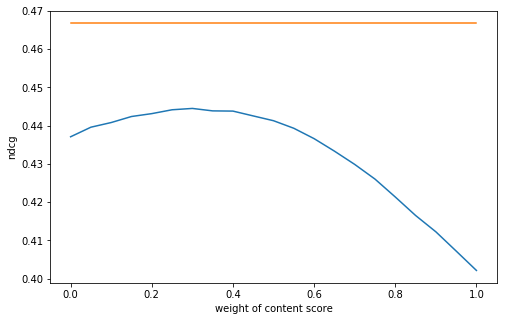

In [17]:
gr4rec_ndcg_mean = gru4rec_log['ndcg'].mean()
plt.figure(figsize=(8,5))
plt.plot(np.linspace(0,1,21), ndcgs, label="combination")
plt.plot(np.linspace(0,1,21), [gr4rec_ndcg_mean]*21, label="gru4rec")
plt.ylabel('ndcg')
plt.xlabel('weight of content score')

In [18]:
a=0.35
scores = a*content_scores + (1-a)*jaccard_scores
ranks = 200-(scores[:,0].reshape(-1,1) > scores[:,1:]).sum(axis=1)+(scores[:,0].reshape(-1,1) == scores[:,1:]).sum(axis=1)/2

In [19]:
combined_order['combined_rank'] = ranks
combined_order['combined_mpr'] = ranks/200
combined_order['combined_ndcg'] = ((ranks<=20)/np.log2(ranks+1))
combined_order['combined_recall'] = (ranks<=20)

In [20]:
combined_order['combined_mpr'].mean(), combined_order['combined_ndcg'].mean(), combined_order['combined_recall'].mean()

(0.08064779082774479, 0.4438780538515632, 0.801565995525727)